<a href="https://colab.research.google.com/github/Yusuf-Abol/jet-rail-forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

Unicorn Investors are considering an investment in an innovative new transportation system called JetRail, which leverages jet propulsion technology to transport passengers at high speeds on specially designed rails. While JetRail has perfected its technology and holds the patent, the investment is contingent on reaching over 1 million monthly users within the next 18 months.


#### - Data Collection

 The data for this problem is provided through the competition hosted on [Analytics Vidhya ](https://www.analyticsvidhya.com/datahack/contest/practice-problem-time-series-2/#ProblemStatement)

## Aim

To assist Unicorn Ventures in making an informed decision regarding their investment in JetRail by forecasting passenger traffic for the next 7 months, providing critical insights into the growth potential and demand trends.


## Objectives

* Look for trends and patterns in the passenger count to help make better predictions.

* Use both basic and advanced forecasting methods to predict passenger counts and see how well they perform.

* Measure how accurate the predictions are using error metrics like MAPE and RMSE.

* See if it is possible to get a prediction error (MAPE) under 10% to improve accuracy.

* Forecast passenger counts for the next 7 months based on past data.



## Import Important Libraries

In [1]:
import os
import random 
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from datetime import datetime
from  pandas import Series


import optuna
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler



from statsmodels.tsa.arima.model import ARIMA 
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

import pickle

import warnings
warnings.filterwarnings("ignore")

## Load Data from Local Machine

In [2]:
train = pd.read_csv("C:\\Users\\DELL\\Desktop\\JetRail-Traffic-Forecasting\\jetrail_train_set.csv")
test = pd.read_csv("C:\\Users\\DELL\\Desktop\\JetRail-Traffic-Forecasting\\jetrail_test_set.csv")

train_set_main = train.copy()
test_set_main = test.copy()

In [3]:
train.head(10)

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2
5,5,25-08-2012 05:00,2
6,6,25-08-2012 06:00,2
7,7,25-08-2012 07:00,2
8,8,25-08-2012 08:00,6
9,9,25-08-2012 09:00,2


## Quick Inspection

In [4]:
train.columns, test.columns

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

In [5]:
train.dtypes, test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object,
 ID           int64
 Datetime    object
 dtype: object)

In [6]:
train.shape, test.shape

((18288, 3), (5112, 2))

## Feature Extraction

I noticed that the datetime data isn’t in the right format. To extract time-based features for the analysis, it needs to be converted to a proper datetime format.

In [7]:
# Conversion to datetime format i.e, day/month/year/hour/minute 
train['Datetime'] = pd.to_datetime(train.Datetime, format = '%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test.Datetime, format = '%d-%m-%Y %H:%M')

train_set_main['Datetime'] = pd.to_datetime(train_set_main.Datetime, format = '%d-%m-%Y %H:%M')
test_set_main['Datetime'] = pd.to_datetime(test_set_main.Datetime, format = '%d-%m-%Y %H:%M')

In [8]:
train

,ID,Datetime,Count
0,0,2012-08-25 00:00:00,8
1,1,2012-08-25 01:00:00,2
2,2,2012-08-25 02:00:00,6
3,3,2012-08-25 03:00:00,2
4,4,2012-08-25 04:00:00,2
...,...,...,...
18283,18283,2014-09-25 19:00:00,868
18284,18284,2014-09-25 20:00:00,732
18285,18285,2014-09-25 21:00:00,702
18286,18286,2014-09-25 22:00:00,580


#### - Extracting year, month, day, and hour from Datetime

In [9]:
# Loop/Extract DataFrame in train, test, train_set_main, and test_set_main
for t in (train, test, train_set_main, test_set_main):
  t['year'] = t.Datetime.dt.year
  t['month'] = t.Datetime.dt.month
  t['day'] = t.Datetime.dt.day
  t['hour'] = t.Datetime.dt.hour

In [10]:
# Creates a new column: 'day of week'
train['day of week'] = train['Datetime'].dt.dayofweek
date_col = train['Datetime']

In [11]:
# Define a function day_type for column containing 1 for weekend dates and 0 for weekdays
#def day_type(row):
#    return 1 if row.dayofweek in [5, 6] else 0

#train['weekend'] = train['Datetime'].apply(day_type)

In [12]:
train['weekend'] = train['Datetime'].dt.dayofweek.isin([5, 6]).astype(int)

In [13]:
train['weekend']

0        1
1        1
2        1
3        1
4        1
        ..
18283    0
18284    0
18285    0
18286    0
18287    0
Name: weekend, Length: 18288, dtype: int32

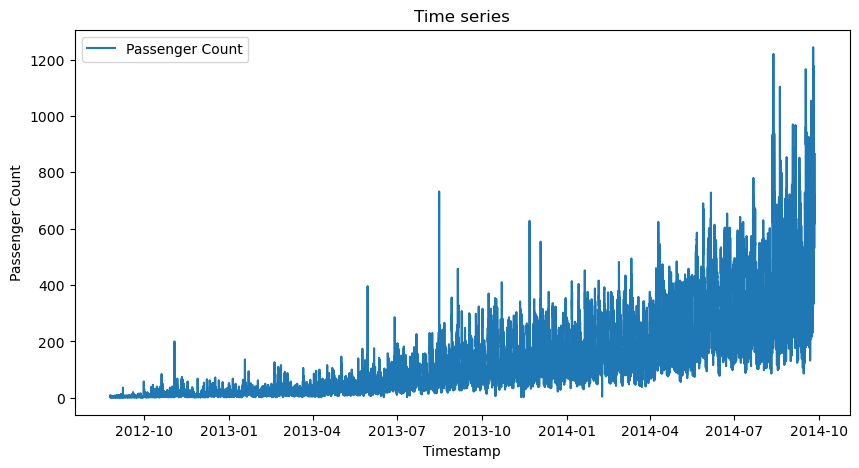

In [14]:
# Indexing the Datetime to get the time period on the X-axis
train.index = train_set_main['Datetime']

# drop ID variable to get only the Datetime on X-axis
df = train.drop('ID', axis=1)

ts = df["Count"]

plt.figure(figsize=(10,5))
plt.plot(ts, label = 'Passenger Count')
plt.title('Time series')

plt.xlabel("Timestamp")
plt.ylabel("Passenger Count")
plt.legend(loc="best");

* The plot indicates an increasing trend in the series, meaning the passenger count rises over time.

* Additionally, certain points in the plot show sudden surges, indicating high traffic on specific days.

## Exploratory Data Analysis

#### - Will traffic continue to increase over the years?

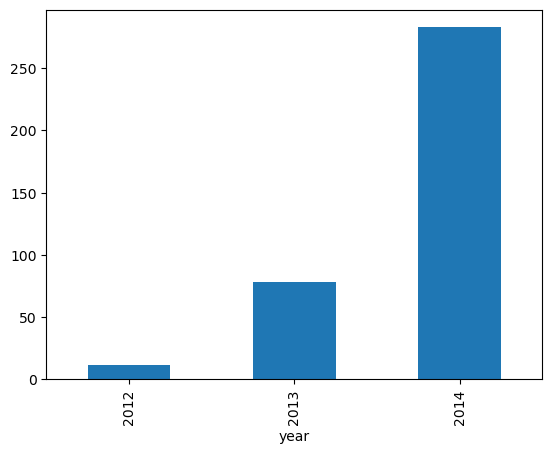

In [15]:
train.groupby('year')['Count'].mean().plot.bar();

#### - Will traffic keep rising over the month? Which months are the busiest?

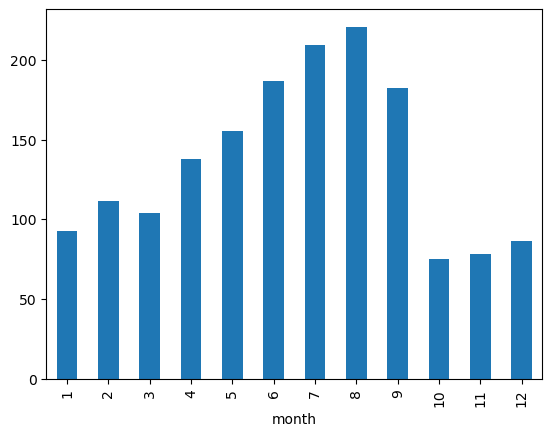

In [16]:
train.groupby('month')['Count'].mean().plot.bar();

#### - Average Passenger Count by year and month

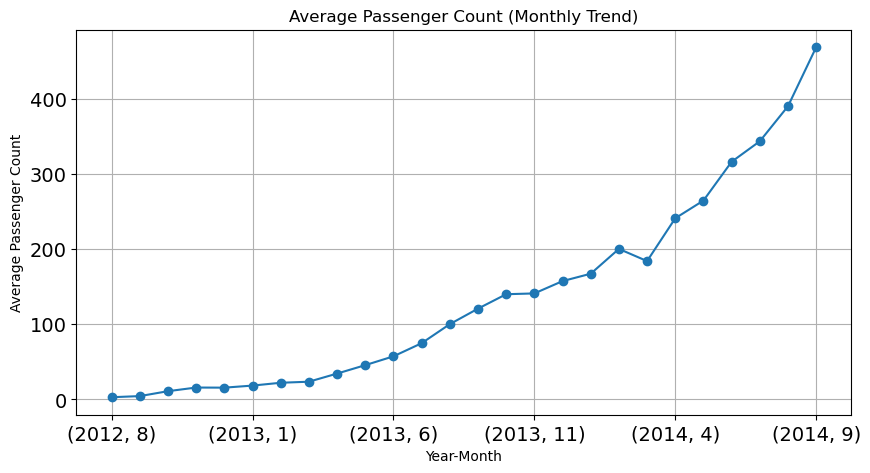

In [17]:
# Grouping data by year and month and computing the mean count
monthly_avg_passengers = train.groupby(['year', 'month'])['Count'].mean()

# Plotting
plt.figure(figsize=(10, 5))
monthly_avg_passengers.plot(marker='o', linestyle='-', title='Average Passenger Count (Monthly Trend)', fontsize=14)

# Adding labels
plt.xlabel('Year-Month')
plt.ylabel('Average Passenger Count')
plt.grid(True)
plt.show()

* Months 10, 11, and 12 are missing for 2014, and the average count for these months in 2012 is relatively low.

* The trend shows a high mean value for the remaining months, driven by larger passenger counts in 2014.

* Additionally, the overall increasing trend in monthly passenger count appears to follow an approximately exponential growth pattern

#### - Average Daily Passenger Count

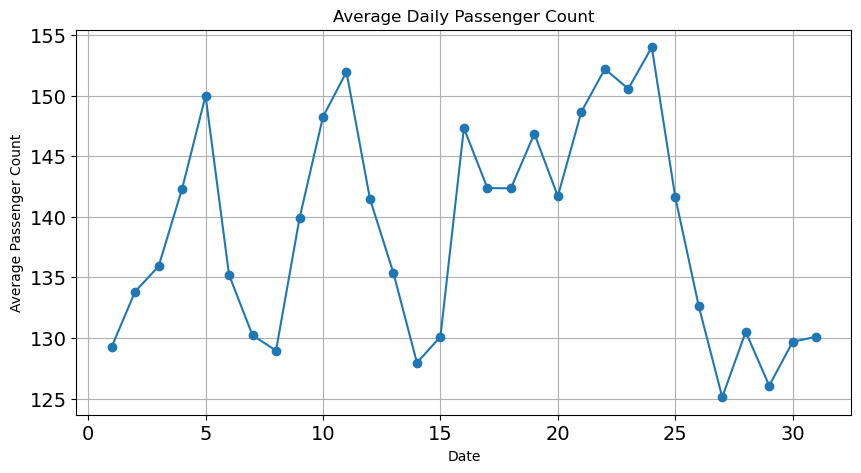

In [18]:
daily_avg_passengers = train.groupby('day')['Count'].mean()

plt.figure(figsize=(10, 5))
daily_avg_passengers.plot(marker='o', linestyle='-', title='Average Daily Passenger Count', fontsize=14)

plt.xlabel('Date')
plt.ylabel('Average Passenger Count')
plt.grid(True)
plt.show()

#### - Average Hourly Passenger Count

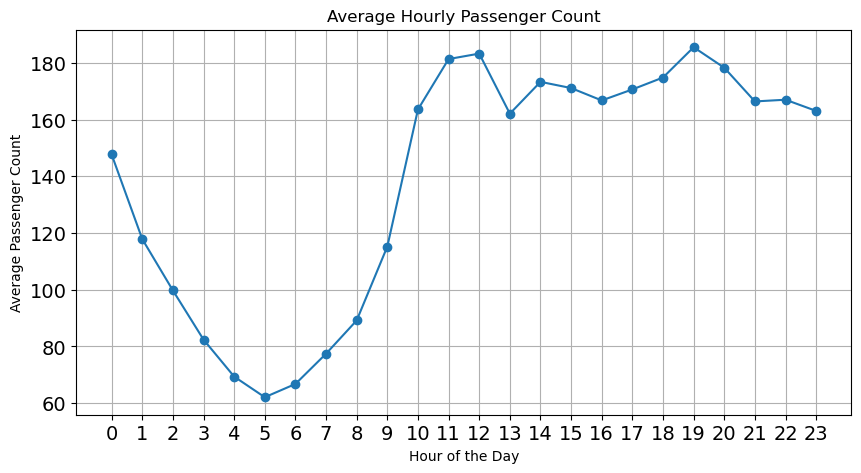

In [19]:
hourly_avg_passengers = train.groupby('hour')['Count'].mean()

plt.figure(figsize=(10, 5))
hourly_avg_passengers.plot(marker='o', linestyle='-', title='Average Hourly Passenger Count', fontsize=14)

plt.xlabel('Hour of the Day')
plt.ylabel('Average Passenger Count')
plt.xticks(range(0, 24))  # Ensures all hours are visible
plt.grid(True)
plt.show()

#### - Passenger Traffic Distribution: Weekdays vs. Weekends

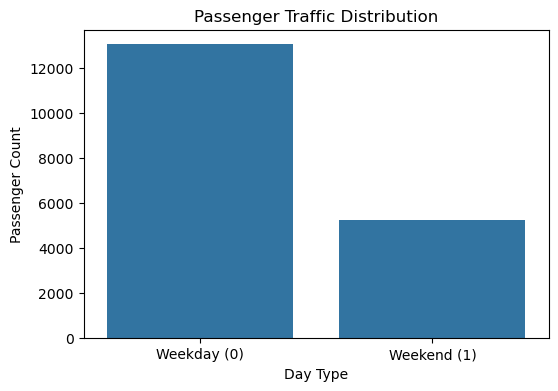

In [20]:
# Count the occurrences of weekend (1) vs weekday (0)
weekend_counts = train['weekend'].value_counts()

# Plotting
plt.figure(figsize=(6, 4))
sns.barplot(x=weekend_counts.index, y=weekend_counts.values)
plt.title('Passenger Traffic Distribution')
plt.xlabel('Day Type')
plt.ylabel('Passenger Count')
plt.xticks([0, 1], ['Weekday (0)', 'Weekend (1)'])
plt.show()

* The plot above shows that traffic is higher on weekdays compared to weekends.

#### - Average Passenger Count by Day of the Week

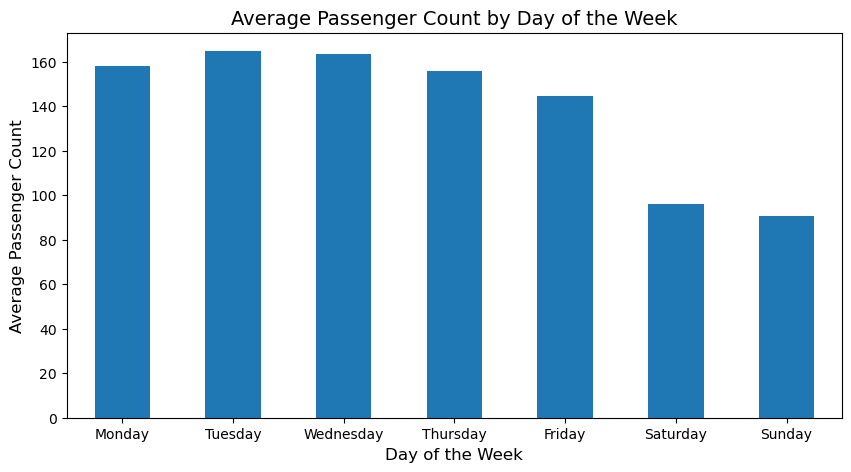

In [21]:
day_order = [
  'Monday', 'Tuesday', 
  'Wednesday', 'Thursday',
  'Friday', 'Saturday', 'Sunday'
  ]
train.groupby('day of week')['Count'].mean().reindex(range(7)).plot.bar(figsize=(10, 5))

plt.title('Average Passenger Count by Day of the Week', fontsize=14)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Average Passenger Count', fontsize=12)
plt.xticks(ticks=range(7), labels=day_order, rotation=0)
plt.show()

#### - Hourly/Daily/Weekly/Monthly Time series

In [22]:
train = train.drop('ID', axis=1)

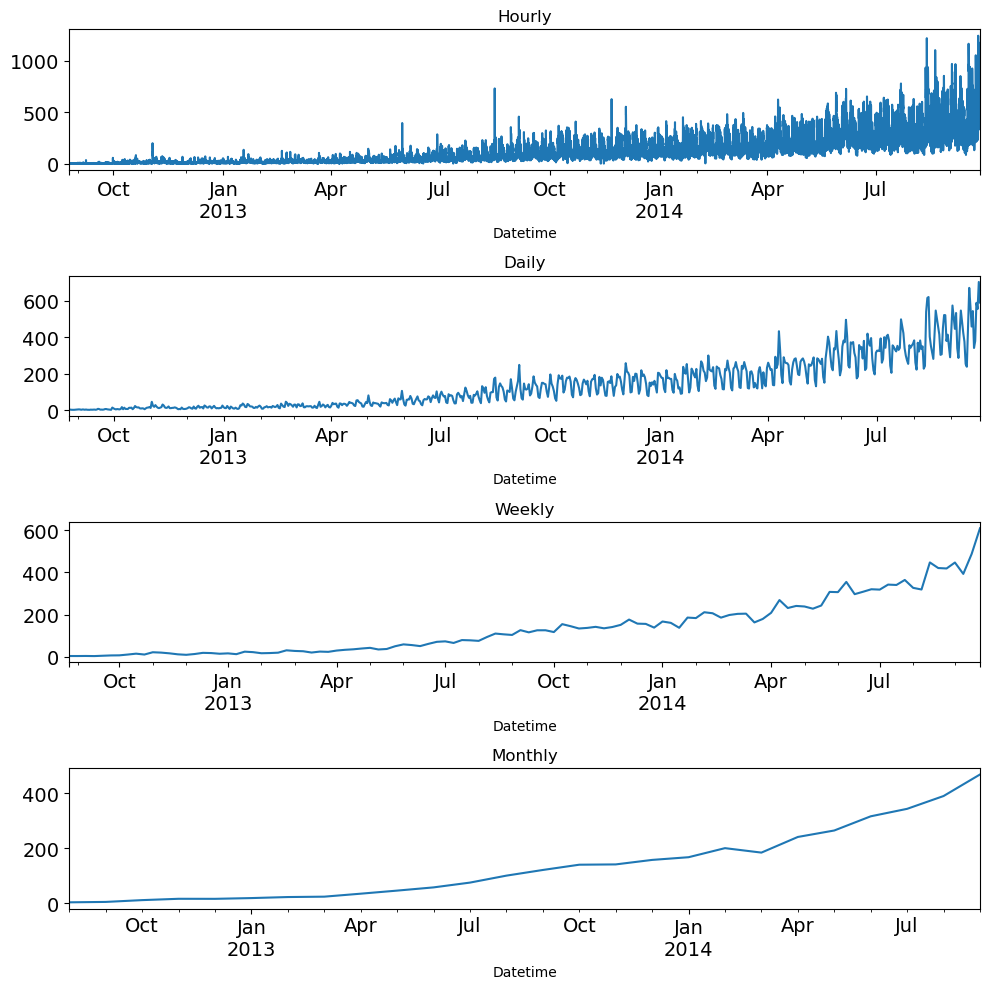

In [23]:
train.Timestamp = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
train.index = train.Timestamp

# Resampling the data for different time frequencies
hourly = train.resample('H').mean()
daily = train.resample('D').mean()
weekly = train.resample('W').mean()
monthly = train.resample('M').mean()

# Plotting all resampled data
fig, axs = plt.subplots(4, 1, figsize=(10, 10))

hourly.Count.plot(title='Hourly', fontsize=14, ax=axs[0])
daily.Count.plot(title='Daily', fontsize=14, ax=axs[1])
weekly.Count.plot(title='Weekly', fontsize=14, ax=axs[2])
monthly.Count.plot(title='Monthly', fontsize=14, ax=axs[3])

plt.tight_layout() 
plt.show()

* The time series becomes more stable as we aggregate it on a daily, weekly, and monthly basis

* Converting the monthly and weekly predictions to hourly ones would be a bit of a hassle.

* So, to keep things simpler, I'll stick with the daily time series.

In [24]:
# Convert 'Datetime' column to datetime and set as index for both train and test
test['Timestamp'] = pd.to_datetime(test['Datetime'], format='%d-%m-%Y %H:%M')
test.set_index('Timestamp', inplace=True)

train['Timestamp'] = pd.to_datetime(train['Datetime'], format='%d-%m-%Y %H:%M')
train.set_index('Timestamp', inplace=True)

# Resample both train and test to daily mean
test = test.resample('D').mean()
train = train.resample('D').mean()

## Split Data

In this section, I will divide the training data into training and validation sets. The training set will be used to build the model, and the validation set will be used to evaluate the accuracy of our predictions.

  - Validation Set: I will take the last 3 months of data as the validation set.

  - Reason for 3 Months: This duration is chosen because it captures the most recent trend, ensuring that the validation set is reflective of the current patterns in the data.

  - Why Not More Than 3 Months: Taking more than 3 months would significantly reduce the number of data points available for training, especially since the total duration of the dataset is 25 months.

  - The starting date of the dataset is 25-08-2012 as we have seen in the exploration part and the end date is 25-09-2014.

In [25]:
# Define the split point based on actual max date
valid_start = train.index.max() - pd.DateOffset(months=3)  
valid_end = train.index.max()  

# Re-split
train_set = train.loc[train.index.min():valid_start]
valid_set = train.loc[valid_start:valid_end]

# Check ranges
print(f"Training Data Range: {train_set.index.min()} to {train_set.index.max()}")
print(f"Validation Data Range: {valid_set.index.min()} to {valid_set.index.max()}")

Training Data Range: 2012-08-25 00:00:00 to 2014-06-25 00:00:00
Validation Data Range: 2014-06-25 00:00:00 to 2014-09-25 00:00:00


In [26]:
print(f"Train set size: {train_set.shape}")
print(f"Validation set size: {valid_set.shape}")

Train set size: (670, 8)
Validation set size: (93, 8)


Here's what's happening:

  - Original dataset: 18,289 data points (likely hourly data).

  - After resampling: We are now aggregating by day, so we get far fewer points (670 for training).

  - This is expected because we are converting from a higher frequency (hourly) to a lower frequency (daily)

#### - Daily Time Series Plot: Training-Validation Split

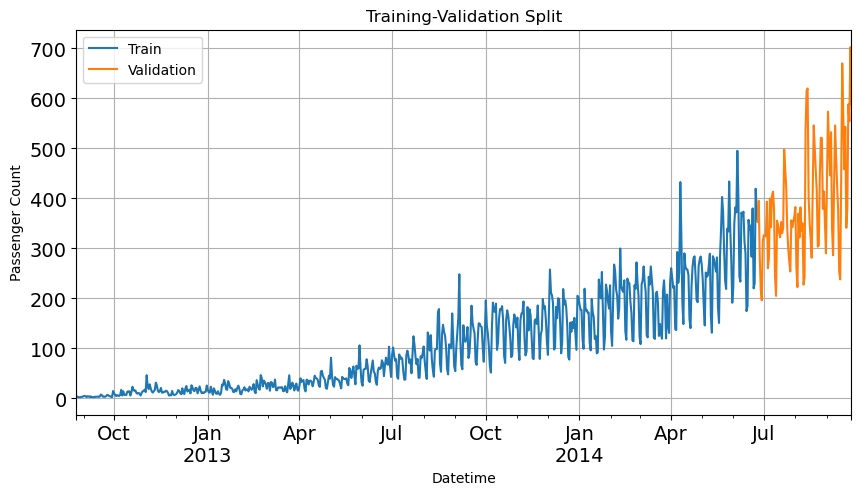

In [27]:
# Plot the train and validation sets
plt.figure(figsize=(10, 5))
train_set.Count.plot(label='Train', title='Training-Validation Split', fontsize=14)
valid_set.Count.plot(label='Validation')
plt.xlabel("Datetime")
plt.ylabel("Passenger Count")
plt.legend()
plt.grid(True)
plt.show()

## Modeling Methodology

#### - Set Reproducibility

In [28]:
def set_reproducibility(seed=42):
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# Set reproducibility
set_reproducibility()

#### - Naive Model

  - It often used as a baseline to compare against more advanced models. 
  - It assumes that the most recent observed value is the best predictor of future values.

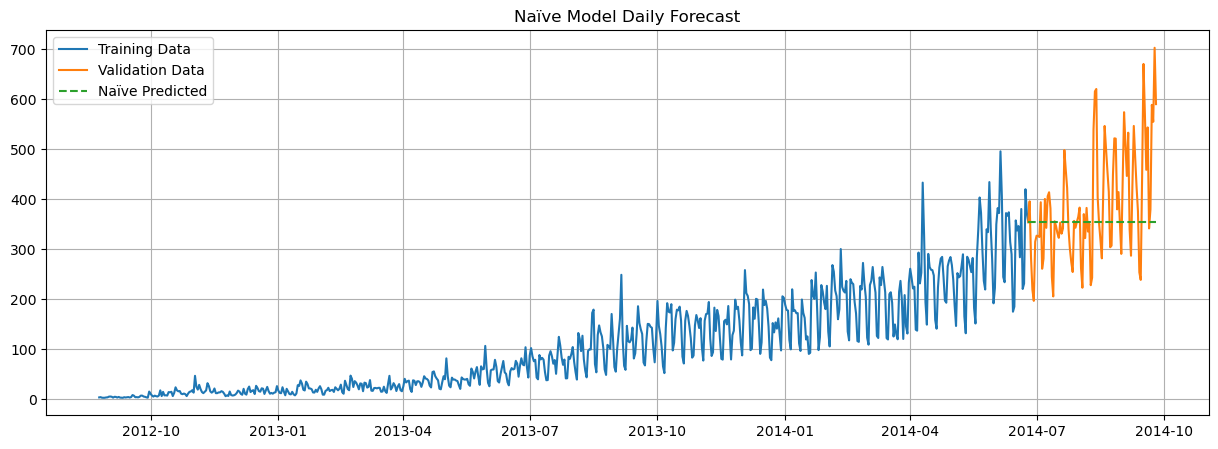

In [29]:
y_hat = valid_set.copy()

# Naïve Model Prediction
y_hat['Naive_Predictions'] = train_set['Count'].iloc[-1]  # Last known value as forecast

# Plot actual vs predicted
plt.figure(figsize=(15,5))
plt.plot(train_set['Count'], label="Training Data")
plt.plot(y_hat['Count'], label="Validation Data")
plt.plot(y_hat['Naive_Predictions'], label="Naïve Predicted", linestyle="dashed")
plt.legend(loc="best")
plt.title("Naïve Model Daily Forecast")
plt.grid(True)
plt.show()

In [30]:
# Calculate RMSE
rmse_NA = np.sqrt(mean_squared_error(y_hat['Count'], y_hat['Naive_Predictions']))

# Compute RMSE
mape_NA = np.mean(np.abs((valid_set['Count'] - y_hat['Naive_Predictions']) / valid_set['Count'])) * 100

# Model Evaluation
print(f'Naive Model Evaluation: RMSE= {rmse_NA:.4f} | MAPE= {mape_NA:.2f}%')

Naive Model Evaluation: RMSE= 116.0739 | MAPE= 21.80%


#### - Moving Average
  -  A simple yet powerful technique for smoothing time series data and making forecasts based on past observations.
  
  - It helps in removing noise and identifying trends in the data.

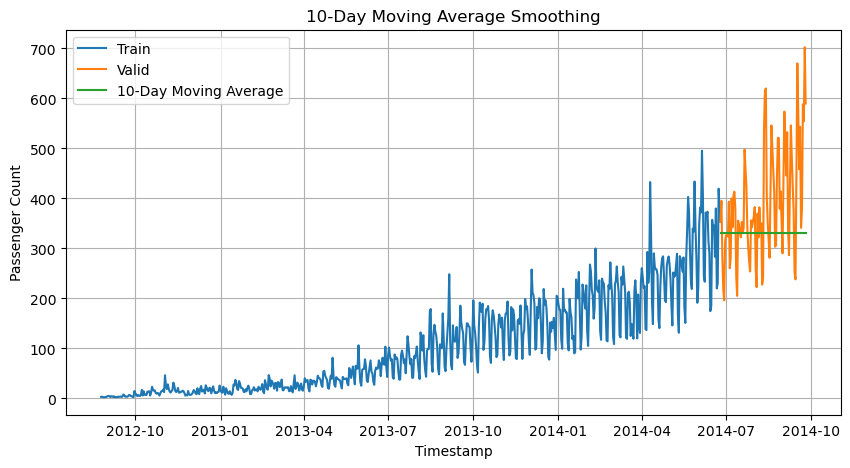

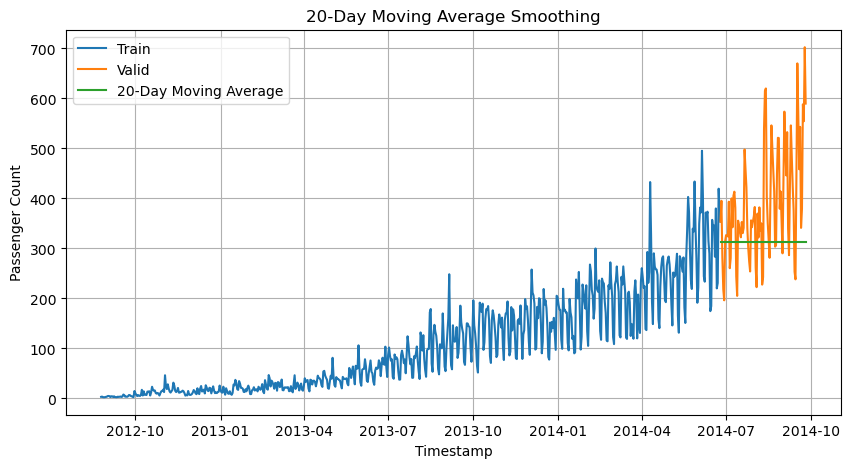

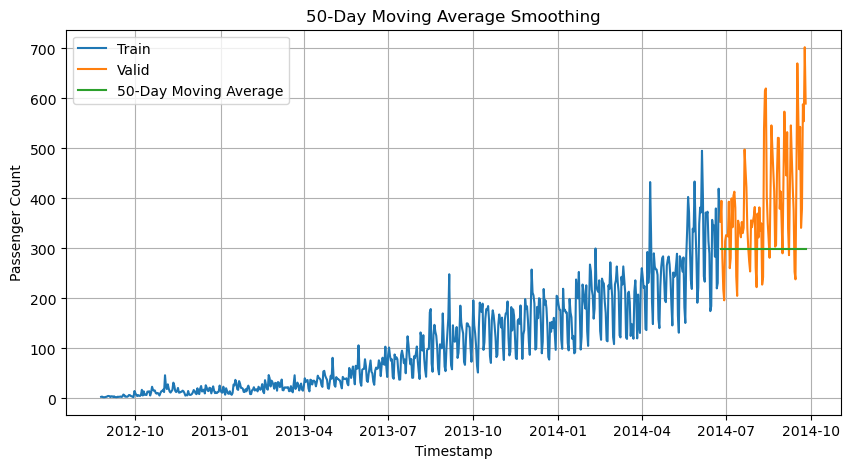

In [31]:
plt.figure(figsize=(10,5))

y_hat0 = valid_set.copy()
y_hat0['Moving_Avg_Forecast'] = train_set['Count'].rolling(window=10, min_periods=1).mean().iloc[-1]
plt.plot(train_set['Count'], label='Train')
plt.plot(valid_set['Count'], label='Valid')
plt.plot(y_hat0['Moving_Avg_Forecast'], label='10-Day Moving Average')

plt.title('10-Day Moving Average Smoothing')
plt.xlabel('Timestamp')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10,5))

y_hat1 = valid_set.copy()
y_hat1['Moving_Avg_Forecast'] = train_set['Count'].rolling(window=20, min_periods=1).mean().iloc[-1]
plt.plot(train_set['Count'], label='Train')
plt.plot(valid_set['Count'], label='Valid')
plt.plot(y_hat1['Moving_Avg_Forecast'], label='20-Day Moving Average')

plt.title('20-Day Moving Average Smoothing')
plt.xlabel('Timestamp')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))

y_hat2 = valid_set.copy()
y_hat2['Moving_Avg_Forecast'] = train_set['Count'].rolling(window=50, min_periods=1).mean().iloc[-1]
plt.plot(train_set['Count'], label='Train')
plt.plot(valid_set['Count'], label='Valid')
plt.plot(y_hat2['Moving_Avg_Forecast'], label='50-Day Moving Average')

plt.title('50-Day Moving Average Smoothing')
plt.xlabel('Timestamp')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# Calculate RMSE
rmse_MA = np.sqrt(mean_squared_error(valid_set['Count'], y_hat0['Moving_Avg_Forecast']))

# Compute RMSE
mape_MA = np.mean(np.abs((valid_set['Count'] - y_hat0['Moving_Avg_Forecast']) / valid_set['Count'])) * 100

# Model Evaluation
print(f'Moving Average Model Evaluation: RMSE= {rmse_MA:.4f} | MAPE= {mape_MA:.2f}%')

Moving Average Model Evaluation: RMSE= 125.4097 | MAPE= 22.09%


### - Simple Exponential Smoothing

  -  It is used for time series data where past observations are weighted exponentially.

  -  Gives more importance to recent data while still considering past values.
  
  -  It is useful for data with no clear trend or seasonality.

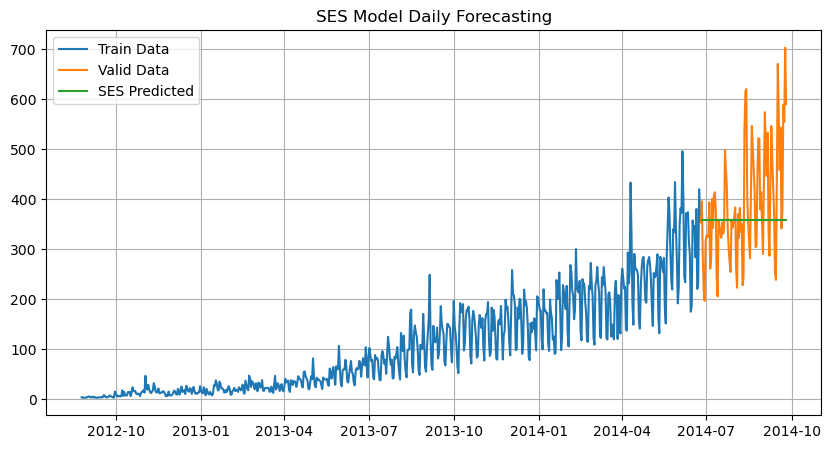

In [33]:
y_hat3 = valid_set.copy()

# Ensure train_set["Count"] is a valid series
fit3 = SimpleExpSmoothing(train_set["Count"]).fit(smoothing_level=0.6, optimized=False)

# Forecast for the validation set length
y_hat3['SES'] = fit3.forecast(len(valid_set))

# Plot results
plt.figure(figsize=(10,5))
plt.title("SES Model Daily Forecasting")
plt.plot(train_set['Count'], label='Train Data')
plt.plot(valid_set['Count'], label='Valid Data')
plt.plot(y_hat3['SES'], label='SES Predicted')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [34]:
y_hat3['SES'].fillna(method='bfill', inplace=True)  # First, fill NaNs

# Calculate RMSE
rmse_SES = np.sqrt(mean_squared_error(valid_set['Count'], y_hat3['SES']))

# Compute RMSE
mape_SES = np.mean(np.abs((valid_set['Count'] - y_hat3['SES']) / valid_set['Count'])) * 100

# Model Evaluation
print(f'SES Model Evaluation: RMSE= {rmse_SES:.4f} | MAPE= {mape_SES:.2f}%')

SES Model Evaluation: RMSE= 114.9250 | MAPE= 22.00%


#### - Holt Linear Trend Model
  -  It is an extension of Simple Exponential Smoothing (SES) but accounts for trends in the data.

  -  Holt's method models both the level and the trend (i.e., the direction and magnitude of change over time)

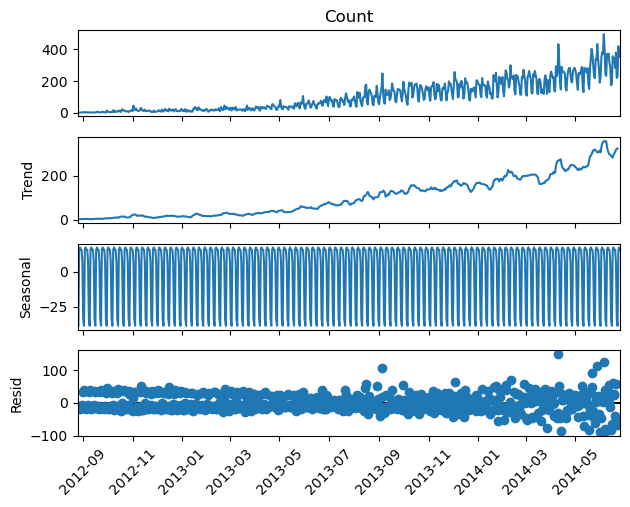

In [35]:
#---------------------------------------------------------------------
# Decompose the time series into trend, seasonal, and residual components
#---------------------------------------------------------------------
sm.tsa.seasonal_decompose(train_set["Count"], model='additive').plot()  # 'additive' or 'multiplicative'
plt.xticks(rotation=45)
plt.show();

* An increasing trend can be seen in the dataset.

* As a result, a Holt model will be built to capture this trend.

### - Hyperparameter Tuning of Holt's model Using Bayesian Optimization

 - Parameters:

    - `alpha` (smoothing level) controls how much weight is given to recent observations.

    - `beta` (smoothing trend) controls how much weight is given to the trend (i.e., the rate of change) in the data.

- Why I tuned it? 

    - Since there is a strong or increasing trend in the dataset default values may not fit your data well.

    - Optimization ensures we searched for the values of alpha and beta that minimize RMSE.

In [36]:
# Define the objective function for Optuna
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.01, 1.0)  # Search range for alpha (level)
    beta = trial.suggest_float('beta', 0.01, 1.0)    # Search range for beta (trend)

    # Fit Holt model with trial parameters
    model = Holt(valid_set['Count']).fit(smoothing_level=alpha, smoothing_trend=beta)
    y_pred = model.forecast(len(valid_set))

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(valid_set['Count'], y_pred))

    return rmse  # Optuna minimizes RMSE

In [37]:
study = optuna.create_study(direction='minimize')  # We want to minimize RMSE
study.optimize(objective, n_trials=100)  # Run 100 trials or more

# Best parameters
best_params = study.best_params
print(f"Best Alpha: {best_params['alpha']}, Best Beta: {best_params['beta']}")
print(f"Best RMSE: {study.best_value}")

[I 2025-04-07 01:51:08,246] A new study created in memory with name: no-name-9e1c8fdb-6598-4601-8b02-1306babc5254
[I 2025-04-07 01:51:08,258] Trial 0 finished with value: 4288.798192590298 and parameters: {'alpha': 0.3812587007841055, 'beta': 0.9034331384438407}. Best is trial 0 with value: 4288.798192590298.
[I 2025-04-07 01:51:08,265] Trial 1 finished with value: 631.3355793378605 and parameters: {'alpha': 0.6217660623616358, 'beta': 0.040950842384726405}. Best is trial 1 with value: 631.3355793378605.
[I 2025-04-07 01:51:08,271] Trial 2 finished with value: 3104.1087524137597 and parameters: {'alpha': 0.49227763818666537, 'beta': 0.731762115147607}. Best is trial 1 with value: 631.3355793378605.
[I 2025-04-07 01:51:08,280] Trial 3 finished with value: 1569.7898556625514 and parameters: {'alpha': 0.13060299687992866, 'beta': 0.9552288092219477}. Best is trial 1 with value: 631.3355793378605.
[I 2025-04-07 01:51:08,286] Trial 4 finished with value: 2471.295286972752 and parameters: {'

Best Alpha: 0.9772817173511358, Best Beta: 0.44752053303529093
Best RMSE: 178.3061807922564


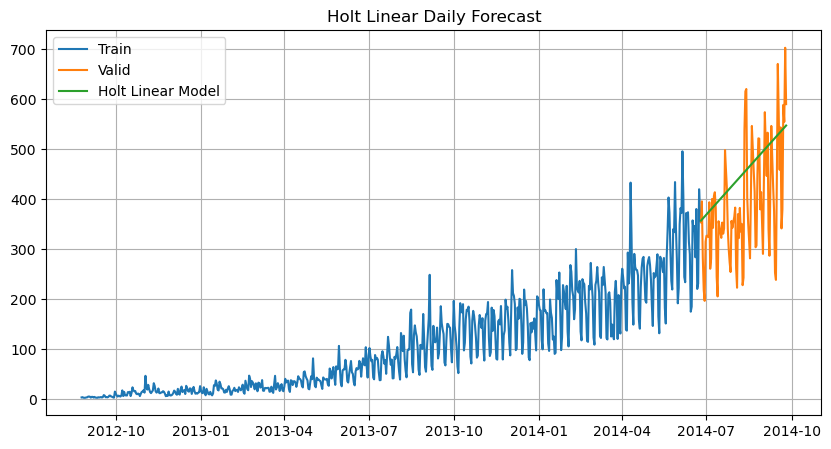

In [38]:
best_alpha = best_params['alpha']
best_beta = best_params['beta']

holt_model = Holt(valid_set['Count']).fit(smoothing_level=best_alpha, smoothing_trend=best_beta)
y_hat_holt = holt_model.forecast(len(valid_set))

# Copy the valid_set to store forecasts
y_hat4 = valid_set.copy()

# Fit the Holt's Linear Trend Model
fit4 = Holt(np.asarray(train_set['Count'])).fit(smoothing_level=best_alpha, smoothing_slope=best_beta)

# Forecast for the length of the valid_set
y_hat4['Holt_linear'] = fit4.forecast(len(valid_set))

# Plot the actual data and forecast
plt.figure(figsize=(10, 5))
plt.title('Holt Linear Daily Forecast')
plt.plot(train_set['Count'], label='Train')
plt.plot(valid_set['Count'], label='Valid')
plt.plot(y_hat4['Holt_linear'], label='Holt Linear Model') 
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [39]:
# Calculate RMSE
rmse_Holt = np.sqrt(mean_squared_error(valid_set['Count'], y_hat4['Holt_linear']))

# Compute RMSE
mape_Holt = np.mean(np.abs((valid_set['Count'] - y_hat4['Holt_linear']) / valid_set['Count'])) * 100

# Model Evaluation
print(f'Holt Linear Model Evaluation: RMSE= {rmse_Holt:.4f} | MAPE= {mape_Holt:.2f}%')

Holt Linear Model Evaluation: RMSE= 113.4171 | MAPE= 29.05%


* The above models failed to account for seasonality in their forecasts.

* Therefore, an approach that considers both trend and seasonality is necessary for accurate forecasting.

* Holt-Winters (Triple Exponential Smoothing), SARIMA (Seasonal ARIMA) or LSTM need to be considered.

#### - Holt Winter's Model 

* It is also known as Triple Exponential Smoothing.

* It is an approach to time series forecasting that captures trend and seasonality.

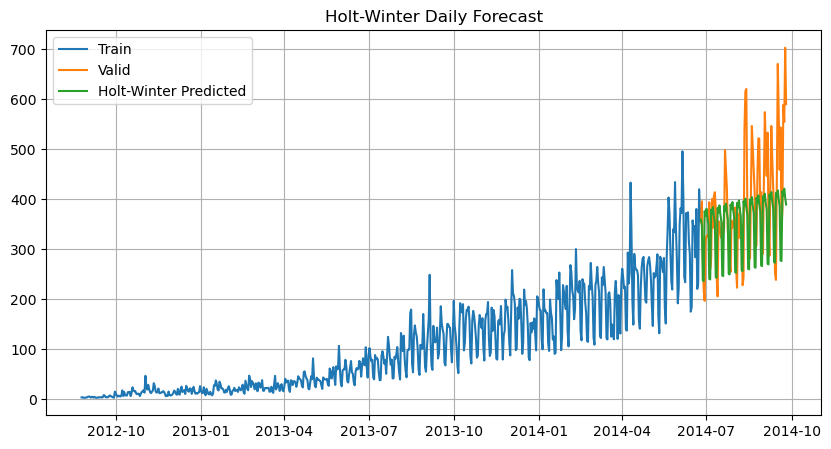

In [40]:
y_hat5 = valid_set.copy()

fit5 = ExponentialSmoothing(
  np.asarray(train_set['Count']), seasonal_periods = 7,
  trend = 'add', seasonal = 'add' 
  ).fit()

y_hat5['Holt_Winter'] = fit5.forecast(len(valid_set))
plt.figure(figsize=(10, 5))
plt.title('Holt-Winter Daily Forecast')
plt.plot(train_set['Count'], label='Train')
plt.plot(valid_set['Count'], label = 'Valid')
plt.plot(y_hat5['Holt_Winter'], label='Holt-Winter Predicted')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [41]:
# Calculate RMSE
rmse_Holt_Wint = np.sqrt(mean_squared_error(valid_set['Count'], y_hat5['Holt_Winter']))

# Compute RMSE
mape_Holt_Wint = np.mean(np.abs((valid_set['Count'] - y_hat5['Holt_Winter']) / valid_set['Count'])) * 100

# Model Evaluation
print(f'Holt Winter Model Evaluation: RMSE= {rmse_Holt_Wint:.4f} | MAPE= {mape_Holt_Wint:.2f}%')

Holt Winter Model Evaluation: RMSE= 111.5876 | MAPE= 22.81%


##  ARIMA Models

* ARIMA stands for AutoRegressive Integrated Moving Average.

* Parameters:
  - `p` (Autoregressive order): The number of lag observations included in the model (how many past values influence the current value).

  - `d` (Degree of differencing): The number of times the data is differenced to make it stationary.

  - `q` (Moving average order): The number of past forecast errors used to model the dependency.

* Assumptions: 

      `Stationarity`, `No Seasonality`, `Minimal Autocorrelation in Residuals`,`Randomly Distributed Residuals`, `Linearity`



#### - Check for Stationarity with Augmented Dickey-Fuller Test

In [42]:
def test_stationarity(timeseries):
    # Rolling statistics
    roll_mean = timeseries.rolling(24).mean()
    roll_std = timeseries.rolling(24).std()
    
    # Plot Rolling Statistics
    plt.figure(figsize=(10,5))
    plt.plot(timeseries, color='blue', label='Original Data')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label='Rolling Std Dev')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Perform Dickey-Fuller Test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # Store results in a Pandas Series
    dfoutput = pd.Series(
        dftest[0:4], 
        index=['Test Statistic', 'p-value', 'Lag Used', 'Number of Observations Used']
    )
    
    # Add critical values
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    
    print(dfoutput)


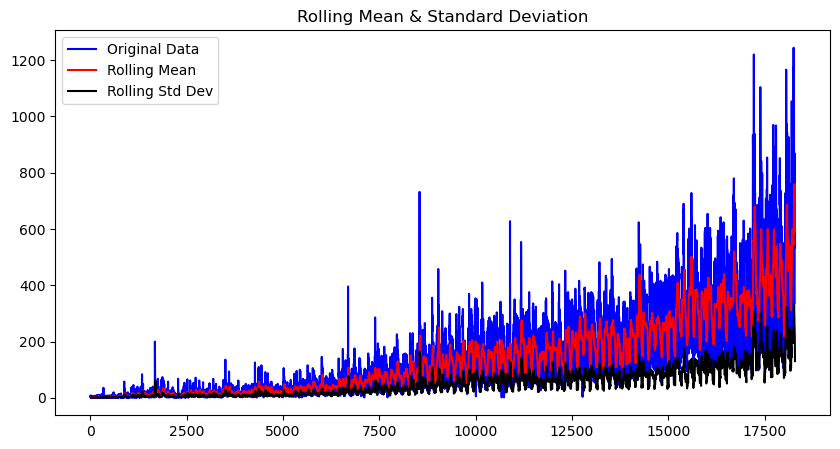

Results of Dickey-Fuller Test:
Test Statistic                    -4.456561
p-value                            0.000235
Lag Used                          45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [43]:
test_stationarity(train_set_main['Count'])

* The output shows that the time series is `stationary` as test statistic is less than critical value.

* The next step is to remove the trend and seasonality in the data.

#### - Remove Trend

* A trend is not necessarily linear; it exists whenever the data shows a long-term increase or decrease.

* Given the upward trend in this dataset, applying a transformation that imposes greater penalties on higher values is more appropriate.

* Assuming a daily cycle of 24 hours, remove trend in the data using a rolling or moving average with a window size of 24.

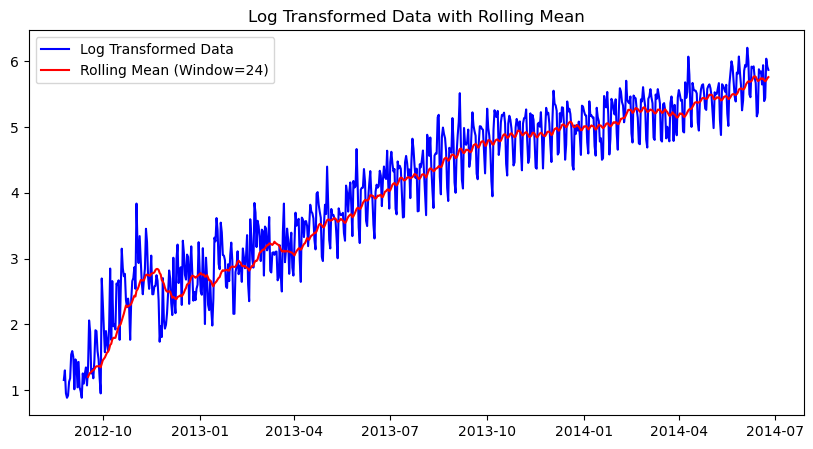

In [44]:
# Apply log transformation
train_log = np.log(train_set['Count'])
valid_log = np.log(valid_set['Count'])

# Compute rolling average
moving_avg = train_log.rolling(window=24).mean()

# Plot original and smoothed series
plt.figure(figsize=(10, 5))
plt.plot(train_log, label='Log Transformed Data', color='blue')
plt.plot(moving_avg, label='Rolling Mean (Window=24)', color='red')
plt.legend(loc='best')
plt.title('Log Transformed Data with Rolling Mean')
plt.show()

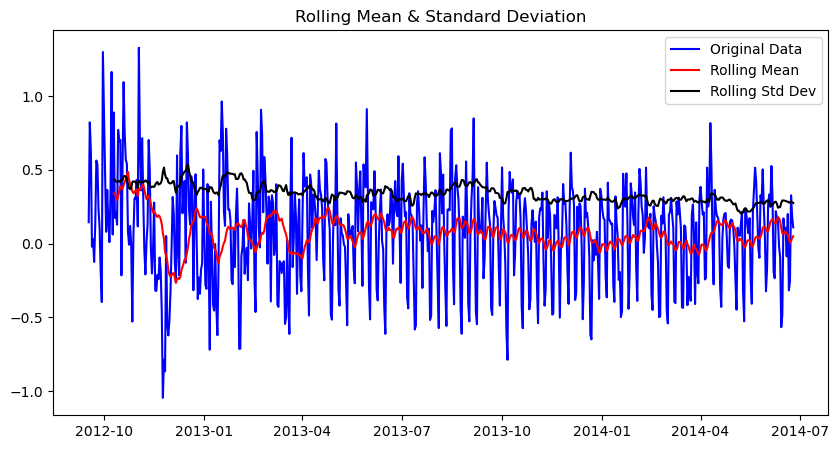

Results of Dickey-Fuller Test:
Test Statistic                -5.867311e+00
p-value                        3.302272e-07
Lag Used                       2.000000e+01
Number of Observations Used    6.260000e+02
Critical Value (1%)           -3.440839e+00
Critical Value (5%)           -2.866168e+00
Critical Value (10%)          -2.569235e+00
dtype: float64


In [45]:
train_log_moving_avg_diff = train_log - moving_avg

train_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(train_log_moving_avg_diff)

#### - Differencing

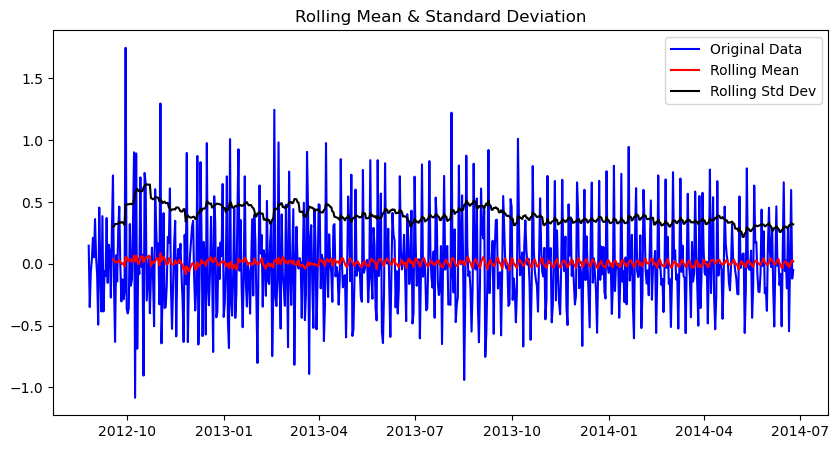

Results of Dickey-Fuller Test:
Test Statistic                -8.253359e+00
p-value                        5.317209e-13
Lag Used                       1.900000e+01
Number of Observations Used    6.490000e+02
Critical Value (1%)           -3.440466e+00
Critical Value (5%)           -2.866004e+00
Critical Value (10%)          -2.569147e+00
dtype: float64


In [46]:
# Differencing
train_log_diff = train_log - train_log.shift(1)
test_stationarity(train_log_diff.dropna())

#### - Remove Seasonality

- Seasonal pattern exists when a series is influenced by seasonal factors like quarters, months, etc

- Seasonality is always of a fixed and known period.

- Use seasonal decompose to decompose the time series into trend, seasonality, and residuals.

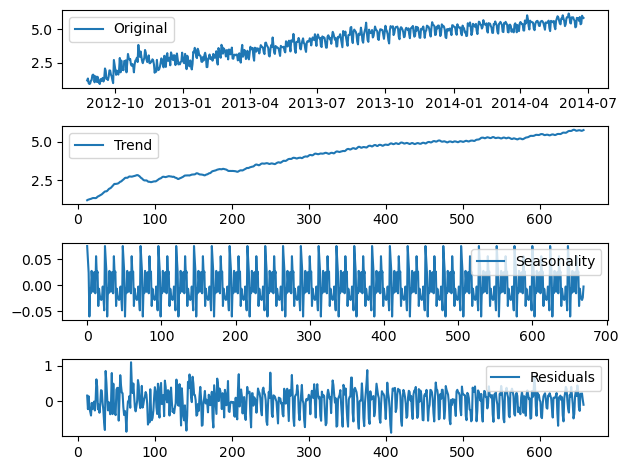

In [47]:
decomposition = seasonal_decompose(pd.DataFrame(train_log).Count.values, period=24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(train_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.legend(loc='best')
plt.tight_layout()
plt.show()

* The seasonal decomposition plot shows a constant seasonal pattern.

* It suggests that the seasonal component is stable over time.

#### - Check for Stationarity of Residuals

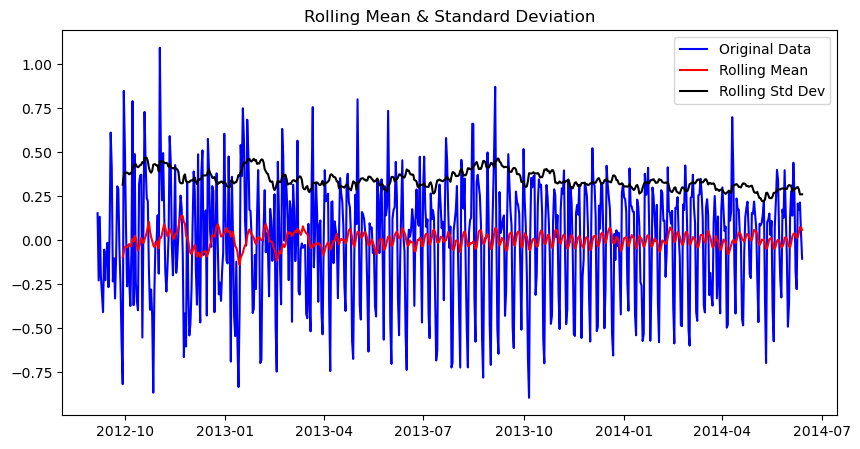

Results of Dickey-Fuller Test:
Test Statistic                -7.830840e+00
p-value                        6.299419e-12
Lag Used                       2.000000e+01
Number of Observations Used    6.250000e+02
Critical Value (1%)           -3.440856e+00
Critical Value (5%)           -2.866175e+00
Critical Value (10%)          -2.569239e+00
dtype: float64


In [48]:
# Convert residual series to DataFrame with proper indexing
train_log_decompose = pd.DataFrame({'residual': residual}, index=train_log.index)

# Drop NaN values
train_log_decompose.dropna(inplace=True)

# Perform stationarity test
test_stationarity(train_log_decompose['residual'])

* The output shows that residuals or errors are stationary.

* It confirms that the trend and seasonality have been successfully removed from the data.

* Also, it suggests that the remaining fluctuations are purely random noise.

## Forecasting Using ARIMA

  - Fit the ARIMA model

  - Use ACF & PACF to find the optimal values for `p`, `d`, and `q`

  - ACF (AutoCorrelation Function): Identifies the MA (q) component.

  - PACF (Partial AutoCorrelation Function): Identifies the AR (p) component.

  - If ADF test  shows p-value < 0.05, the data is already stationary (no differencing needed, d=0).

  - Otherwise, we apply first-order differencing (d=1) and test again.

#### - Manual Computation of ACF and PACF Plot

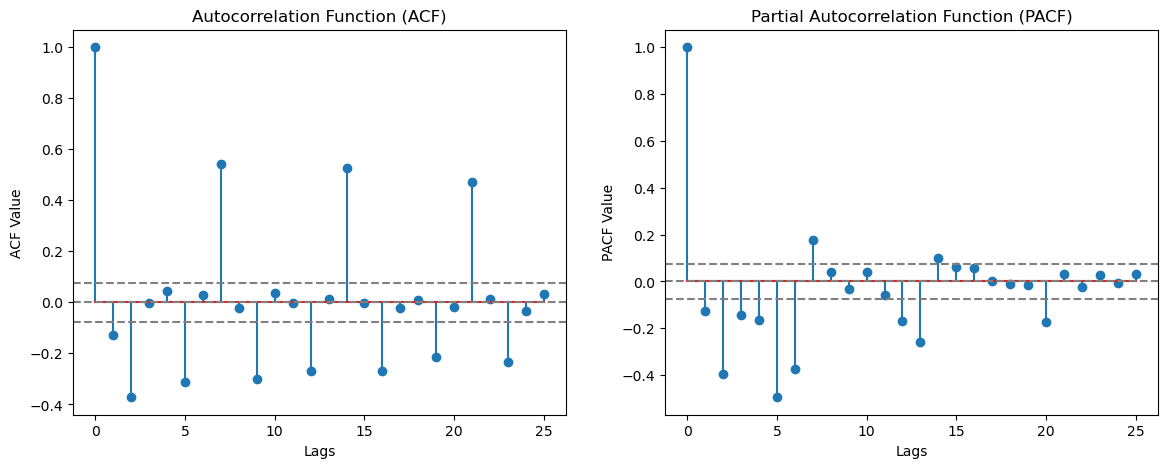

In [49]:

# Compute ACF and PACF values
lag_acf = acf(train_log_diff.dropna(), nlags=25)
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')

# Define figure size
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot ACF
axes[0].stem(range(len(lag_acf)), lag_acf)
axes[0].axhline(y=0, linestyle='--', color='gray')
axes[0].axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())), linestyle='--', color='gray')
axes[0].axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())), linestyle='--', color='gray')
axes[0].set_title("Autocorrelation Function (ACF)")
axes[0].set_xlabel("Lags")
axes[0].set_ylabel("ACF Value")

# Plot PACF
axes[1].stem(range(len(lag_pacf)), lag_pacf)
axes[1].axhline(y=0, linestyle='--', color='gray')
axes[1].axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())), linestyle='--', color='gray')
axes[1].axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())), linestyle='--', color='gray')
axes[1].set_title("Partial Autocorrelation Function (PACF)")
axes[1].set_xlabel("Lags")
axes[1].set_ylabel("PACF Value")

plt.show()


#### - Auto-Computation of ACF & PACF Plot

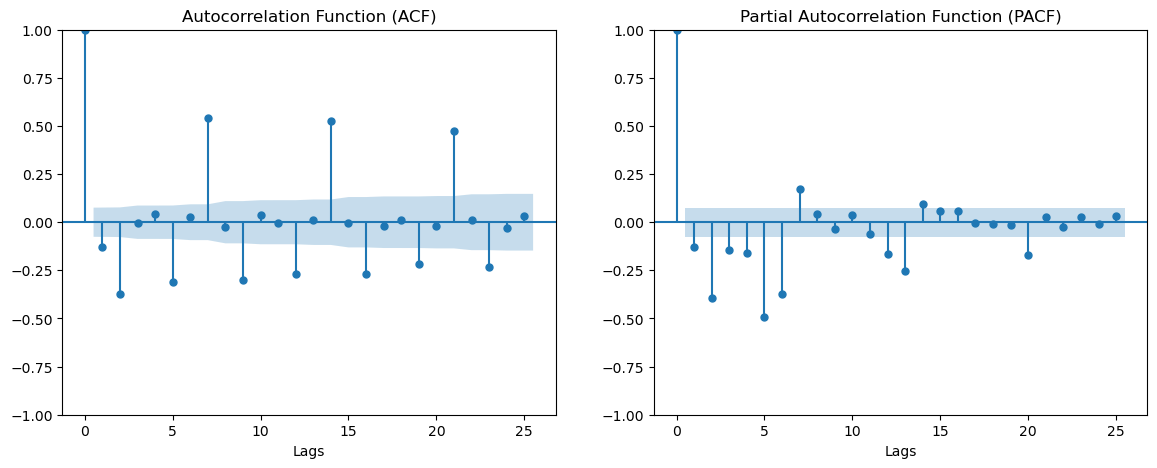

In [50]:

# Define figure size
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF Plot (for MA component q)
plot_acf(train_log_diff.dropna(), ax=axes[0], lags=25)
axes[0].set_title("Autocorrelation Function (ACF)")
axes[0].set_xlabel("Lags")

# PACF Plot (for AR component p)
plot_pacf(train_log_diff.dropna(), ax=axes[1], lags=25)
axes[1].set_title("Partial Autocorrelation Function (PACF)")
axes[1].set_xlabel("Lags")

plt.show()

#### - Interpretation

* PACF Plot 

    - The significant spikes at a few initial lags followed by a rapid drop suggest an AR process.

   - It can be noticed that in this case p is 2 based on rise of the spikes from left to right.

* ACF Plot

  - The presence of gradually decreasing correlations suggests a moving average (MA) process.

  - It can be noticed that in this case q is 3 based on rise of the spikes from left to right.

## AR Model

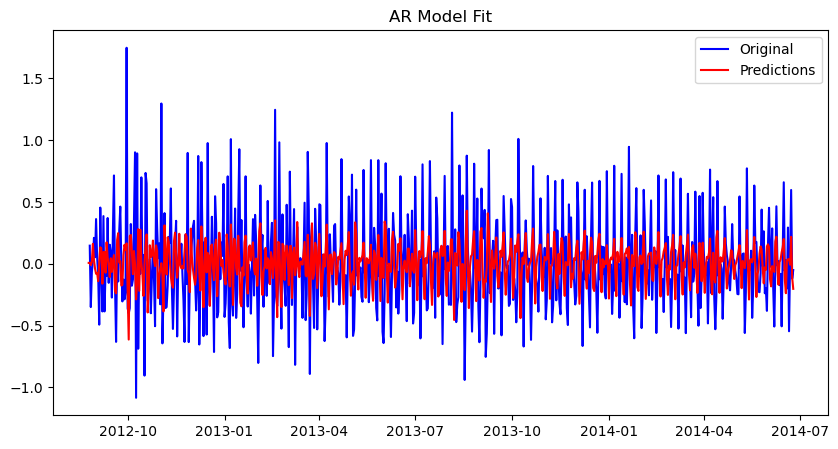

In [51]:
# Define ARIMA model (p=2, d=0, q=0)
model_AR = ARIMA(train_log_diff, order=(2, 0, 0))

# Fit the model
result_AR = model_AR.fit()

# Plot the original differenced series and fitted values
plt.figure(figsize=(10,5))
plt.plot(train_log_diff, color= 'blue', label='Original')
plt.plot(result_AR.fittedvalues, color='red', label='Predictions')
plt.legend(loc='best')
plt.title('AR Model Fit')
plt.show()

## MA Model

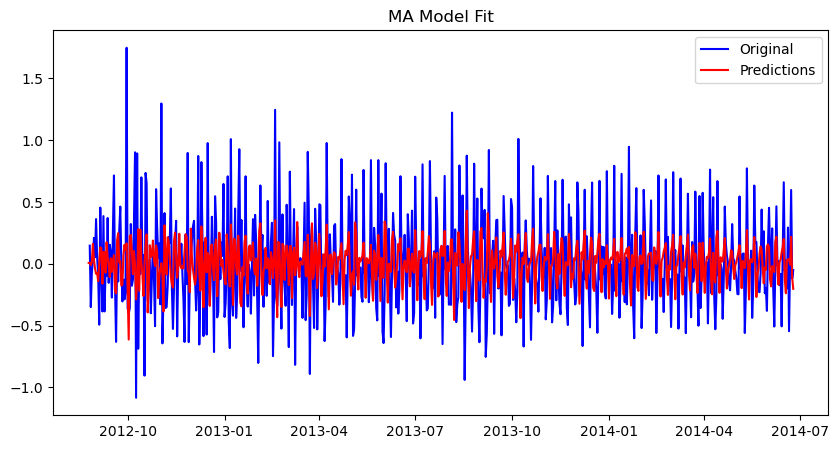

In [52]:
# Define ARIMA model (p=2, d=0, q=0)
model_MA = ARIMA(train_log_diff, order=(0, 0, 3))

# Fit the model
result_MA = model_MA.fit()

# Plot the original differenced series and fitted values
plt.figure(figsize=(10,5))
plt.plot(train_log_diff, color= 'blue', label='Original')
plt.plot(result_AR.fittedvalues, color='red', label='Predictions')
plt.legend(loc='best')
plt.title('MA Model Fit')
plt.show()

## ARIMA Model (AR + 0 + MA Combined)

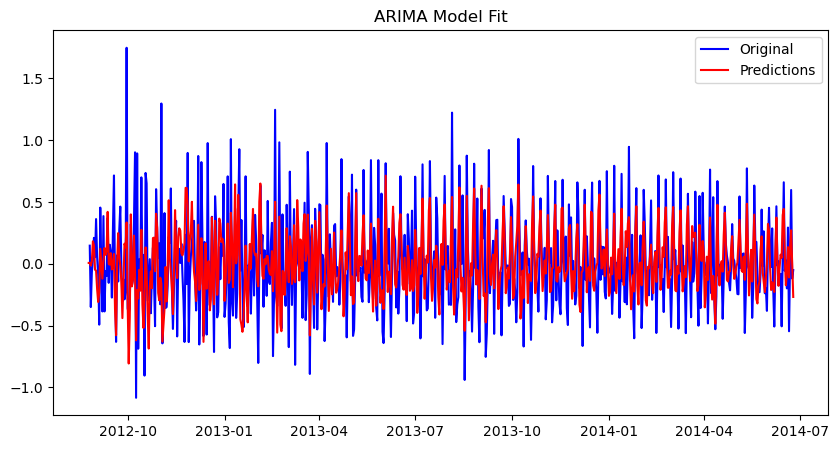

In [53]:
# Define ARIMA model (p=2, d=1, q=0)
model_ARIMA = ARIMA(train_log_diff, order=(2, 0, 3))

# Fit the model
result_ARIMA = model_ARIMA.fit()

# Plot the original differenced series and fitted values
plt.figure(figsize=(10,5))
plt.plot(train_log_diff, color= 'blue', label='Original')
plt.plot(result_ARIMA.fittedvalues, color='red', label='Predictions')
plt.legend(loc='best')
plt.title('ARIMA Model Fit')
plt.show()

#### - Evaluate Forecasting Model's Predictions

In [54]:
def check_prediction_diff(result_model, model_name="Model"):
    predict_model = result_model.predict(start=valid_set.index[0], end=valid_set.index[-1])

    predict_base = pd.Series(np.full(valid_set.shape[0], np.log(valid_set['Count'].iloc[0])), index=valid_set.index)
    predict_log = predict_base.add(predict_model, fill_value=0)
    predict_model = np.exp(predict_log)

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(valid_set['Count'], predict_model))

    # Compute MAPE
    mape = np.mean(np.abs((valid_set['Count'] - predict_model) / valid_set['Count'])) * 100

    # Plot actual vs predicted values with RMSE and MAPE in title
    plt.figure(figsize=(10, 5))
    plt.plot(valid_set['Count'], label='Valid', color='blue')
    plt.plot(predict_model, label='Predicted', color='red', linestyle="dashed")
    plt.legend(loc='best')
    plt.grid(True)

    # Use model_name in the title
    plt.title(f'{model_name} Model Evaluation: RMSE= {rmse:.4f} | MAPE= {mape:.2f}%')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.show()

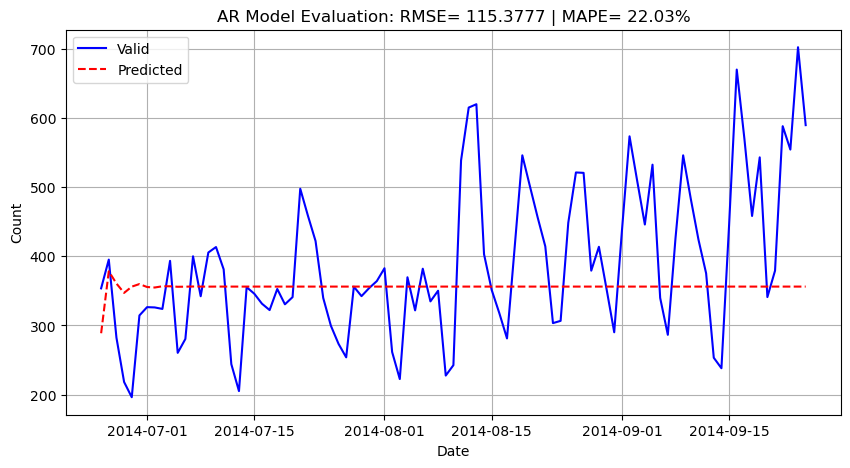

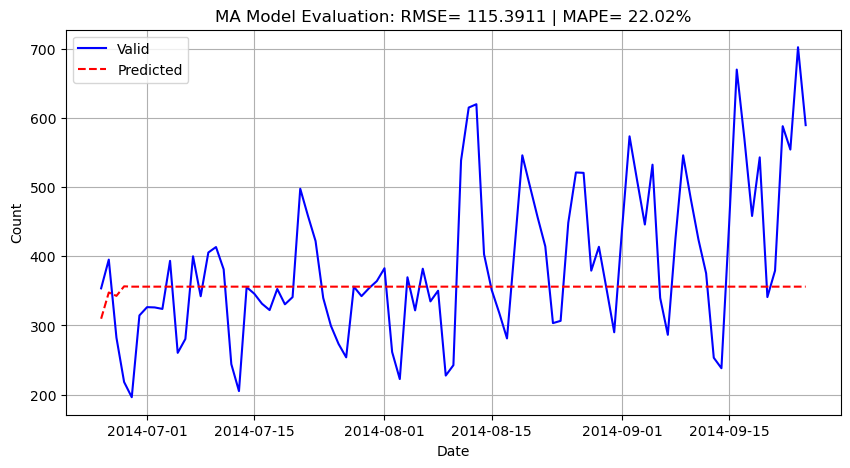

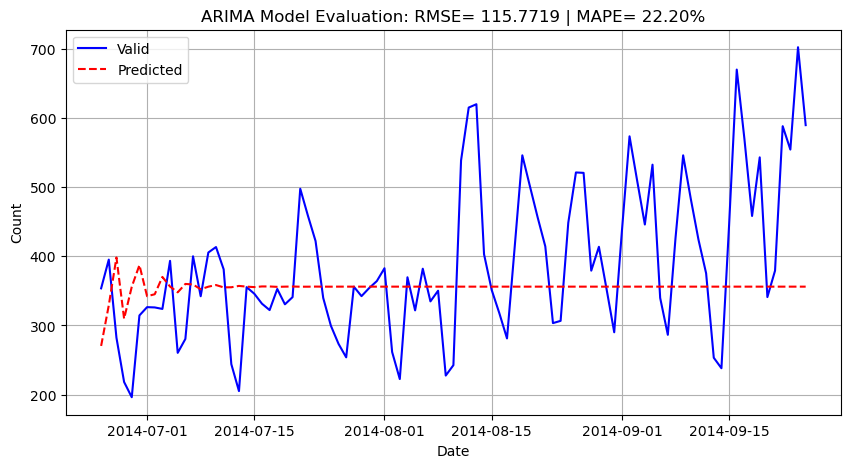

In [55]:
check_prediction_diff(result_AR, model_name='AR')
check_prediction_diff(result_MA, model_name='MA')
check_prediction_diff(result_ARIMA, model_name='ARIMA')

* With a MAPE of around 20%, it appears that the models are not capturing the variability in the data effectively. 

* The predictions are nearly constant, suggesting that the models might be too simplistic for the complexity of the dataset.

## SARIMAX

* SARIMAX stands for Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors

* An extension of the ARIMA model with seasonal components and external variables like economic indicators, weather, or other time series

* Model Parameters:
  
  - `p`, `d`, `q` are the non-seasonal parameters (`AR`, `I`, `MA`).

  - `P`,`D`, `Q` are the seasonal parameters (`seasonal AR`, `seasonal I`, `seasonal MA`).

  - `m` is the number of periods in a season (e.g., 12 for monthly data with yearly seasonality).

* Assumptions: 

      `Stationarity`  `Homoscedasticity`  `No Autocorrelation in Residuals`

      `Normal Residuals` `Linearity` `No Multicollinearity (for Exogenous Variables)`

      `Linearity of Relationships (for Exogenous Variables)` `Independence of Observations`

#### - SARIMAX Forecast

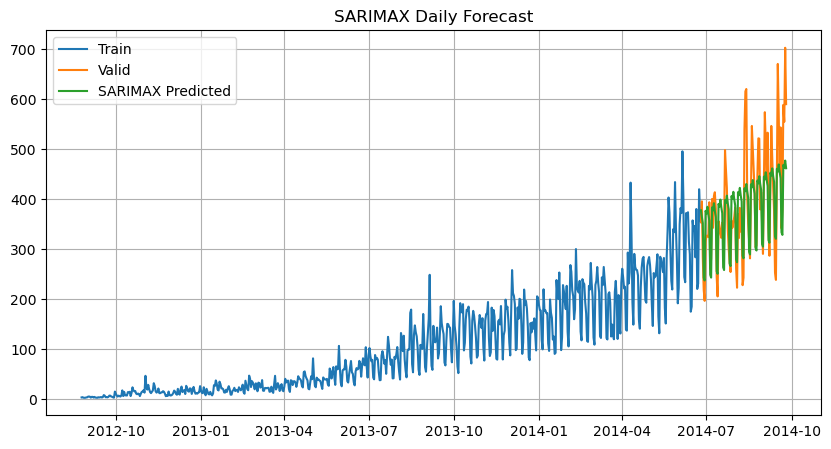

In [56]:
yhat= valid_set.copy()

# Define SARIMAX model (p, d, q) × (P, D, Q, m)
sarimax_fit= sm.tsa.statespace.SARIMAX(train_set['Count'], order=(2,1,4), seasonal_order=(0,1,1,7)).fit()

yhat['SARIMA'] = sarimax_fit.predict(start="2014-6-25", end="2014-9-25", dynamic=True)

plt.figure(figsize=(10,5))
plt.title('SARIMAX Daily Forecast')
plt.plot(train_set['Count'], label='Train')
plt.plot(valid_set['Count'], label='Valid')
plt.plot(yhat['SARIMA'], label='SARIMAX Predicted')
plt.legend(loc='best')
plt.grid(True)
plt.show()

#### - Forecast Evaluation

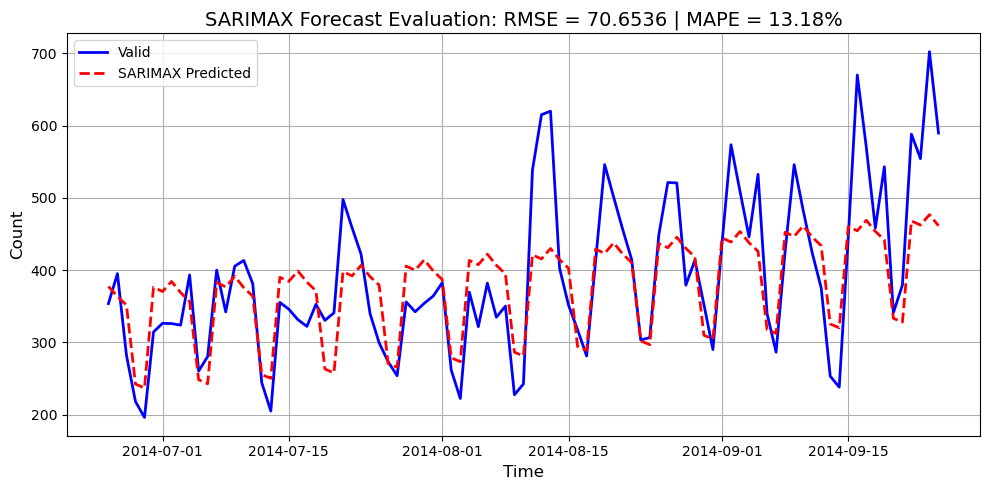

In [57]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(valid_set['Count'], label='Valid', color='blue', linestyle='-', linewidth=2)
plt.plot(yhat['SARIMA'], label='SARIMAX Predicted', color='red', linestyle='--', linewidth=2)

# Compute RMSE
rmse_SARIMAX = np.sqrt(mean_squared_error(valid_set['Count'], yhat['SARIMA']))
# Compute MAPE
mape_SARIMAX = np.mean(np.abs((valid_set['Count'] - yhat['SARIMA']) / valid_set['Count'])) * 100

# Adding RMSE and MAPE to the plot
plt.title(f'SARIMAX Forecast Evaluation: RMSE = {rmse_SARIMAX:.4f} | MAPE = {mape_SARIMAX:.2f}%', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(loc='best')
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

## Bi-Directional Gated Recurrent Unit (BiGRU)

* A bidirectional RNN with only the input and forget gates.

* It consists of two GRUs. One GRU input in a *forward direction*, and the other GRU in a *backwards direction*.

*  Hidden states from both directions provides the model with context from both past and future tokens at each time step.

* Useful for sequence labeling, speech recognition, and other tasks where context in both directions is beneficial.


//

  * GRU's CORE ARCHITECTURE

      * `Reset Gate`  `r`  Controls how much of the previous state to forget.

      * `Update Gate` `z`  Determines how much of the previous state should be carried forward.

      * `Candidate Hidden State` `h῀`  A potential new hidden state, using the reset-modified previous state.

      * `Final Hidden State` `h` Linear interpolation between the old state and the new candidate.

      

In [58]:
# Create lag features for both training and validation sets
train_set["lag_7"] = train_set["Count"].shift(7)
valid_set["lag_7"] = valid_set["Count"].shift(7)

# Drop NaN values created by the shift
train_set.dropna(inplace=True)
valid_set.dropna(inplace=True)

# Normalize the training and validation data
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit scaler on the training data and transform both train and validation sets
train_scaled = scaler.fit_transform(train_set[['Count', 'lag_7']].values)
valid_scaled = scaler.transform(valid_set[['Count', 'lag_7']].values)

In [59]:
time_steps = 10  # Time steps for GRU model

# Create sequences for LSTM/GRU input
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])  # Use both features for each time step (2 features: 'Count' and 'lag_7')
        y.append(data[i + time_steps, 0])  # The next value to predict (Count)
    return np.array(X), np.array(y)

# Create sequences for both train and valid sets
X_train, y_train = create_sequences(train_scaled, time_steps)
X_valid, y_valid = create_sequences(valid_scaled, time_steps)

# Check the shape before reshaping
print("X_train shape before reshaping:", X_train.shape)
print("X_valid shape before reshaping:", X_valid.shape)

X_train shape before reshaping: (653, 10, 2)
X_valid shape before reshaping: (76, 10, 2)


In [60]:
# Build the GRU Model
model = Sequential([
    # First GRU layer
    Bidirectional(GRU(150, return_sequences=True, input_shape=(time_steps, 2))),  # Bidirectional GRU
    # Second GRU layer
    Bidirectional(GRU(150, return_sequences=False)),
    # Dense layer
    Dense(50, activation='relu'),
    # Output layer
    Dense(1)
])

In [61]:
# Compile the model with Adam optimizer and MSE loss function
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1)

# Train the model
model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=1, callbacks=[lr_scheduler])

# Predict on Validation Set
gru_predictions = model.predict(X_valid, verbose=0)

# Get the lag_7 values from the last 'time_steps' observations of the validation set
lag_7_predictions = valid_set['Count'].shift(7).iloc[time_steps:].values.reshape(-1, 1)

# Combine 'Count' predictions with 'lag_7' to create a 2-feature input for inverse transformation
gru_predictions_combined = np.concatenate((gru_predictions, lag_7_predictions), axis=1)

# Inverse transform the predictions to original scale
gru_predictions_inv = scaler.inverse_transform(gru_predictions_combined)

Epoch 1/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0239 - learning_rate: 0.0010
Epoch 2/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0104 - learning_rate: 0.0010
Epoch 3/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0067 - learning_rate: 0.0010
Epoch 4/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0065 - learning_rate: 0.0010
Epoch 5/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0055 - learning_rate: 0.0010
Epoch 6/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0048 - learning_rate: 0.0010
Epoch 7/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0042 - learning_rate: 0.0010
Epoch 8/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0041 - learning_rate: 0.0010
Epoch 9/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0039 - learning_rate: 0.0010
Epoch 10/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0038 - learning_rate: 0.0010
Epoch 11/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0038 - learning_rate: 0.0

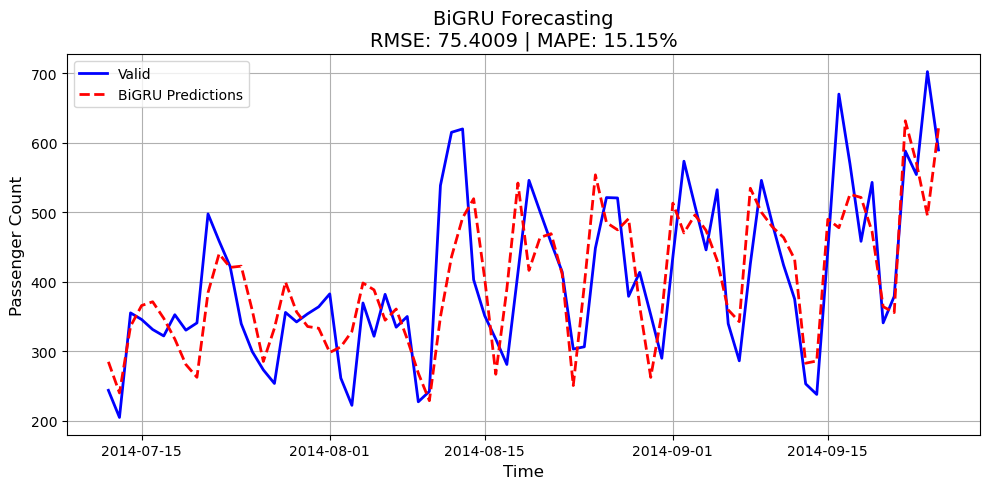

In [62]:
# Compute Evaluation Metrics (RMSE and MAPE)
rmse_gru = np.sqrt(mean_squared_error(valid_set['Count'][time_steps:], gru_predictions_inv[:, 0]))
mape_gru = np.mean(np.abs((valid_set['Count'][time_steps:] - gru_predictions_inv[:, 0]) / valid_set['Count'][time_steps:])) * 100

# Plot Results
plt.figure(figsize=(10, 5))

# Plot actual values (validation set)
plt.plot(valid_set.index[time_steps:], valid_set['Count'][time_steps:], label="Valid", color="blue", linewidth=2)

# Plot GRU predictions (aligned with the validation period)
plt.plot(valid_set.index[time_steps:], gru_predictions_inv[:, 0], label="BiGRU Predictions", color="red", linestyle="--", linewidth=2)

# Add titles and labels
plt.title(f"BiGRU Forecasting\nRMSE: {rmse_gru:.4f} | MAPE: {mape_gru:.2f}%", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Passenger Count", fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [63]:

#gru_predictions_scaled = gru_predictions_original_scale[:, 0].flatten() 
gru_predictions_scaled = gru_predictions_inv[:, 0].flatten()  # Get only the first column (residual predictions)

# Add NaNs for the first 'time_steps' as the model starts predicting after 'time_steps'
y_hat_GRU = valid_set.copy()
y_hat_GRU['GRU'] = np.concatenate([np.full((time_steps,), np.nan), gru_predictions_scaled])

# Ensure the length of the resulting array matches the validation set
assert len(y_hat_GRU['GRU']) == len(valid_set), "Length mismatch between GRU predictions and validation set."

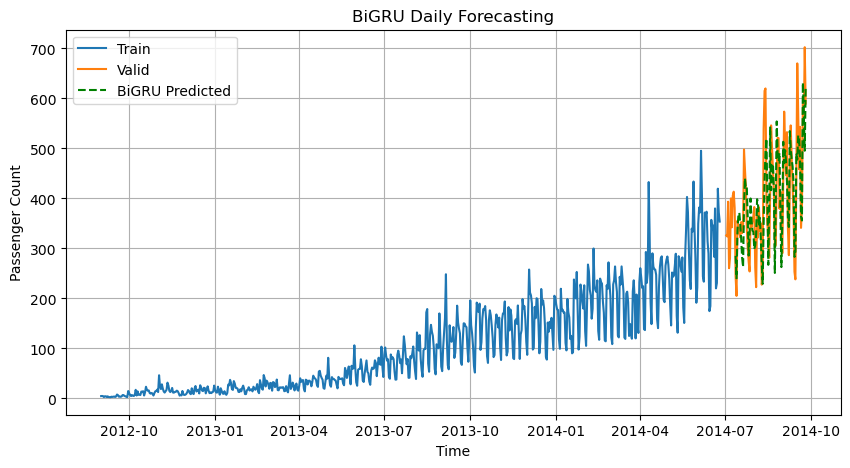

In [64]:
# Plot the training set, validation set, and GRU predictions
plt.figure(figsize=(10, 5))
plt.plot(train_set['Count'], label='Train')
plt.plot(valid_set['Count'], label='Valid')
plt.plot(y_hat_GRU['GRU'], label='BiGRU Predicted', linestyle='--', color='green')

plt.legend(loc='best')
plt.grid(True)
plt.title('BiGRU Daily Forecasting')
plt.xlabel('Time')
plt.ylabel('Passenger Count')
plt.show()


## Hybrid SARIMAX + BiGRU Model

* A combination of statistical and deep learning models with robust forecast that accounts for both linear and non-linear dynamics.

* SARIMAX captures trends and seasonality while BiGRU handles sudden shifts and noise missed by SARIMAX.



In [65]:
# Predict SARIMAX on validation range
sarimax_preds = sarimax_fit.predict(start=len(train_set), end=len(train_set)+len(valid_set)-1)

# Compute residuals

train_residuals = train_set['Count'] - sarimax_fit.fittedvalues
valid_residuals = valid_set['Count'] - sarimax_preds


# Add residuals + lag feature

train_set['residual'] = train_residuals
valid_set['residual'] = valid_residuals

# Add lag feature (e.g. 7-day lag)
train_set['residual_lag_7'] = train_set['residual'].shift(7)
valid_set['residual_lag_7'] = valid_set['residual'].shift(7)

# Drop NaNs created by shift
train_set.dropna(inplace=True)
valid_set.dropna(inplace=True)

In [66]:
# Normalize and sequence the residuals
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_set[['residual', 'residual_lag_7']])
valid_scaled = scaler.transform(valid_set[['residual', 'residual_lag_7']])

time_steps = 30

def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(data[i + time_steps, 0])  # predict residual
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, time_steps)
X_valid, y_valid = create_sequences(valid_scaled, time_steps)

In [67]:
# GRU model to learn residuals
gru_model = model

gru_model.fit(X_train, y_train, epochs=150, batch_size=64, verbose=1, callbacks=[lr_scheduler])

# Predict GRU residuals & combine

gru_residual_preds = gru_model.predict(X_valid)

# Trim SARIMAX predictions to match GRU output
# Ensure both arrays are the same length
sarimax_preds_for_combination = sarimax_preds.iloc[-gru_residual_preds.shape[0]:].values.reshape(-1, 1)

# Combine SARIMAX + GRU predictions
final_predictions = gru_residual_preds + sarimax_preds_for_combination

Epoch 1/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0104 - learning_rate: 9.0949e-16
Epoch 2/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0104 - learning_rate: 9.0949e-16
Epoch 3/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0104 - learning_rate: 9.0949e-16
Epoch 4/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0104
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.547473724858043e-16.
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0104 - learning_rate: 9.0949e-16
Epoch 5/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0104 - learning_rate: 4.5475e-16
Epoch 6/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0104 - learning_rate: 4.5475e-16
Epoch 7/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0104
Epoch 7: ReduceLROnPlateau reducing learning rate to 2.2737368624290214e-16.
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0104 - learning_rate: 4.5475e-16
Epoch 8/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0104 - lea

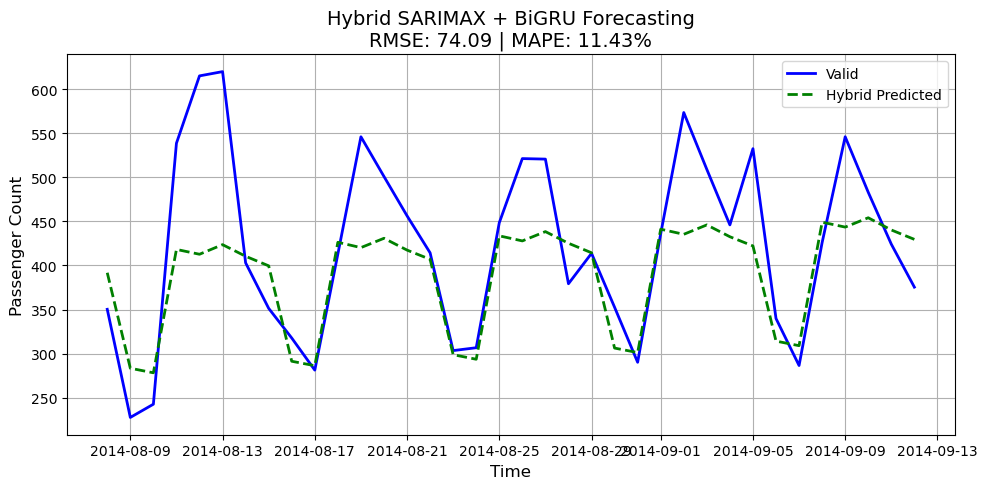

In [68]:
# Evaluation
actuals = valid_set['Count'].iloc[time_steps:].values.reshape(-1, 1)
rmse = np.sqrt(mean_squared_error(actuals, final_predictions))
mape = mean_absolute_percentage_error(actuals, final_predictions) * 100

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(valid_set.index[time_steps:], actuals, label="Valid", color="blue", linewidth=2)
plt.plot(valid_set.index[time_steps:], final_predictions, label="Hybrid Predicted", color="green", linestyle="--", linewidth=2)
plt.title(f"Hybrid SARIMAX + BiGRU Forecasting\nRMSE: {rmse:.2f} | MAPE: {mape:.2f}%", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Passenger Count", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [69]:
# Assign SARIMAX predictions
yhat_hybrid = valid_set.copy()
yhat_hybrid['SARIMA'] = sarimax_preds

# Extract only first column of GRU predictions (passenger counts), and align both
aligned_bigru_preds = gru_predictions_inv[time_steps:, 0]
aligned_sarimax_preds = yhat_hybrid['SARIMA'].iloc[time_steps:]

# Ensure both prediction arrays are the same length
min_len = min(len(aligned_sarimax_preds), len(aligned_bigru_preds))
aligned_sarimax_preds = aligned_sarimax_preds[:min_len]
aligned_bigru_preds = aligned_bigru_preds[:min_len]

# Compute hybrid average
hybrid_preds = (aligned_sarimax_preds.values + aligned_bigru_preds)/2

# Create aligned DataFrame for plotting
hybrid_index = aligned_sarimax_preds.index
yhat_hybrid_aligned = valid_set.loc[hybrid_index].copy()
yhat_hybrid_aligned['Hybrid'] = hybrid_preds

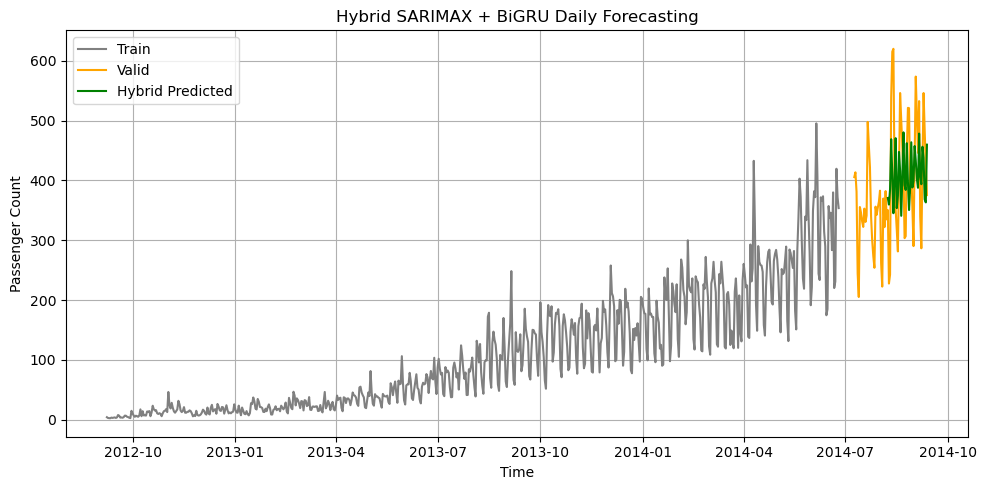

In [70]:
plt.figure(figsize=(10, 5))
plt.plot(train_set['Count'], label='Train', color='gray')
plt.plot(valid_set['Count'], label='Valid', color='orange')
#plt.plot(yhat_hybrid_aligned['Hybrid'], label='Hybrid Predicted', color='green')
# Use the aligned hybrid predictions (starting after time_steps)
plt.plot(yhat_hybrid_aligned.index, yhat_hybrid_aligned['Hybrid'], label='Hybrid Predicted', color='green')


plt.legend(loc='best')
plt.grid(True)
plt.title('Hybrid SARIMAX + BiGRU Daily Forecasting')
plt.xlabel('Time')
plt.ylabel('Passenger Count')
plt.tight_layout()
plt.show()

## Forecast 210 days ahead: A 7-month Horizon for Investors

In [71]:
# Forecast 210 days ahead (7 months)
sarimax_future = sarimax_fit.get_forecast(steps=210)
sarimax_preds_future = sarimax_future.predicted_mean  # This is a Pandas Series with future dates as index

# Extract only first column of GRU predictions (passenger counts), and align both
aligned_bigru_preds = gru_predictions_inv[time_steps:, 0]
aligned_sarimax_preds = yhat_hybrid['SARIMA'].iloc[time_steps:]

# Ensure both prediction arrays are the same length
min_len = min(len(aligned_sarimax_preds), len(aligned_bigru_preds))
aligned_sarimax_preds = aligned_sarimax_preds[:min_len]
aligned_bigru_preds = aligned_bigru_preds[:min_len]

In [72]:
# Extract only first column of GRU predictions (passenger counts), and align both
aligned_bigru_preds = gru_predictions_inv[time_steps:, 0]
aligned_sarimax_preds = yhat_hybrid['SARIMA'].iloc[time_steps:]

# Ensure both prediction arrays are the same length
min_len = min(len(aligned_sarimax_preds), len(aligned_bigru_preds))
aligned_sarimax_preds = aligned_sarimax_preds[:min_len]
aligned_bigru_preds = aligned_bigru_preds[:min_len]

In [73]:
# Predict 210 future days
gru_forecast_scaled = []
# Extract the last 'time_steps' values from aligned_bigru_preds
# Adjust current_input to have 2 features per time step
current_input = np.stack([aligned_bigru_preds[-time_steps:], aligned_bigru_preds[-time_steps:]], axis=-1)
current_input = current_input.reshape(1, time_steps, 2)


for _ in range(210):
    next_pred = gru_model.predict(current_input)  # Predict the next value
    gru_forecast_scaled.append(next_pred[0][0])  # Append predicted value to list
    
    # Reshape next_pred into the correct shape (1, 1, 2), as two identical features
    next_pred_reshaped = np.array([next_pred[0][0], next_pred[0][0]]).reshape(1, 1, 2)
    
    # Update current_input by removing the first time step and appending the new prediction
    current_input = np.append(current_input[:, 1:, :], next_pred_reshaped, axis=1)


# Inverse transform
# Reshape the predicted values to have 2 features (duplicating the predicted values)
gru_forecast_scaled = np.array(gru_forecast_scaled).reshape(-1, 1)
gru_forecast_scaled_2d = np.hstack([gru_forecast_scaled, gru_forecast_scaled])  # Duplicate for 2 features

# Inverse transform using the scaler
gru_preds_future = scaler.inverse_transform(gru_forecast_scaled_2d).flatten()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━

In [74]:
# Ensure both predictions are of the same length (210 days)
sarimax_preds_future = sarimax_preds_future[:210]  # SARIMAX predictions (210 days)
gru_preds_future = gru_preds_future[:210]  # GRU predictions (210 days)

# Combine predictions
hybrid_preds_future = (sarimax_preds_future + gru_preds_future) / 2

In [75]:
# Create an index for the next 210 days, matching your forecast horizon
valid_index = pd.date_range(start=train_set.index[-1] + pd.Timedelta(days=1), periods=210, freq='D')

# Create a new DataFrame for valid_set (make sure it has 210 days)
valid_set = pd.DataFrame(index=valid_index)

# Now you can assign the hybrid predictions
yhat_hybrid_aligned = valid_set.copy()
yhat_hybrid_aligned['Hybrid'] = hybrid_preds_future  # hybrid_preds_future should have 210 days

In [76]:
valid_set

""
2014-06-26
2014-06-27
2014-06-28
2014-06-29
2014-06-30
...
2015-01-17
2015-01-18
2015-01-19
2015-01-20


In [77]:
yhat_hybrid_aligned['Hybrid']

2014-06-26    499.926211
2014-06-27    497.316216
2014-06-28    227.615999
2014-06-29    225.108131
2014-06-30    501.376076
                 ...    
2015-01-17    485.245109
2015-01-18    477.686746
2015-01-19    547.725283
2015-01-20    539.991402
2015-01-21    545.294114
Freq: D, Name: Hybrid, Length: 210, dtype: float64

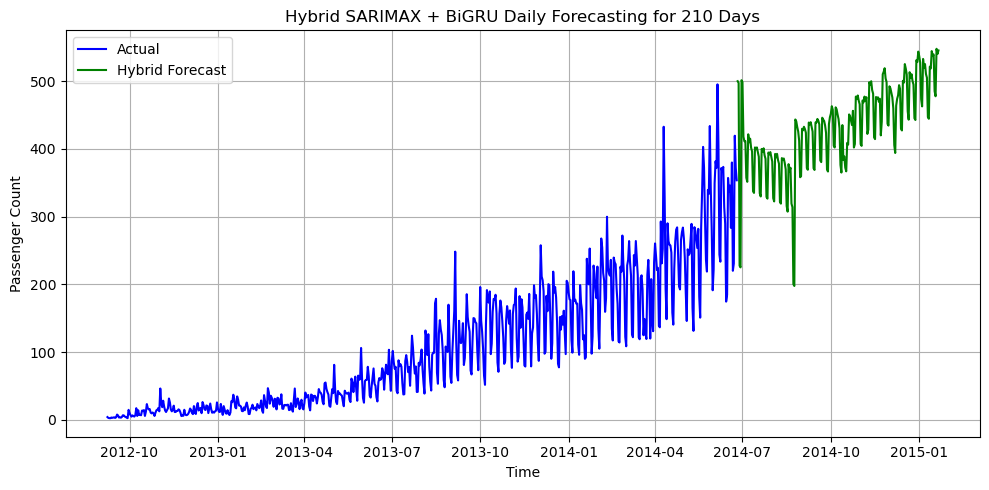

In [78]:
# Plotting
plt.figure(figsize=(10, 5))

# Plot actual training data
plt.plot(train_set['Count'], label='Actual', color='blue')
# Plot actual validation data (next 210 days)
plt.plot(yhat_hybrid_aligned.index, abs(yhat_hybrid_aligned['Hybrid']), label='Hybrid Forecast', color='green')

# Customize the plot
plt.legend(loc='best')
plt.grid(True)
plt.title('Hybrid SARIMAX + BiGRU Daily Forecasting for 210 Days')
plt.xlabel('Time')
plt.ylabel('Passenger Count')
plt.tight_layout()

# Show the plot
plt.show()

## Save Model

In [79]:
# Pickle SARIMAX model (since sarimax_fit is the trained SARIMAX model)
with open('sarimax_model.pkl', 'wb') as f:
    pickle.dump(sarimax_fit, f)
    
    
# Save the BiGRU model in the Keras format
gru_model.save('bigru_model.keras')

## Conclusion

* There is a clear upward trend in passenger counts over the three years, with a particularly steep increase from 2013 to 2014. This exponential growth suggests that the transportation system experienced significant development or adoption during this period, transitioning from a low-usage system in 2012 to a heavily utilized one by 2014.

* Also, it is a transportation system heavily influenced by typical workweek patterns. Weekdays see high demand, especially during rush hours. Weekends, on the other hand, have significantly lower demand.

* The data shows cyclical pattern with multiple peaks and troughs throughout the month suggesting variablity in passenger demand. A higher count in summer months (June-August) suggest a tourist-driven demand.

* The Hybrid model’s forecast for 210 days (July 2014 to January 2015) shows a plausible continuation of the actual data’s patterns, maintaining a range of 300–500 passengers with high variability and weekly cycles. The forecast predicts a sharp increase around October 2014, a drop, and then another rise toward January 2015, which could reflect seasonal trends or events.